# 本文件说明
- 训练模型,查看模型结果：包括K-fold、概率结果

# 基本设置

In [1]:
import jieba
from jieba import analyse
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif 
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.nlp.generate_keywords import generate_keywords
from toolkits.nlp import myclass_circ
from toolkits.nlp import myclass_cbrc

## 一些函数

In [3]:
def title_content_label(filepath):
    title = []
    filename = filepath + 'titles.txt'
    fid = open(filename, "r+", encoding='UTF-8')
    for f in fid:
        title.append(f.strip().replace('\n', ''))
    fid.close()
    print('title num: ', len(title))
    print(title[:2])

    content = []
    filename = filepath + 'contents.txt'
    fid = open(filename, "r+", encoding='UTF-8')
    for f in fid:
        content.append(f.strip().replace('\n', ''))
    fid.close()
    print('content num: ', len(content))
    # content[:2]

    title_content = [t + ' ' + c for t,c in zip(title, content)]
    print('title_content num: ', len(title_content))

    label = []
    filename = filepath + 'labels.txt'
    fid = open(filename, "r+", encoding='UTF-8')
    for f in fid:
        label.append(f.strip().replace('\n', ''))
    fid.close()
    print('label num: ', len(label))
    print(label[:5])
    
    return title_content, label

In [4]:
def cal_kfold(title_content, label, pipeline, raw_folder, filename):
    from sklearn.model_selection import KFold
    import numpy as np

    data_raw = pd.read_excel('%s/corpus/title_content_label.xlsx'%raw_folder)
    raw_title = np.array(data_raw['title'])
    raw_content = np.array(data_raw['content'])
    print('data_raw: ', data_raw.shape)

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    title_content = np.array(title_content)
    label = np.array(label)
    
    kfold_res = {'raw_title':[], 'raw_content':[], 'label':[], 
             'predict_label':[], 'title_content':[], 'predict_proba':[]}

    num = 0
    for train_index , test_index in kf.split(title_content):
        print('---- %s'%(num+1))
        X_train,X_test = title_content[train_index], title_content[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        pipeline.fit(X_train, y_train)
        print(pipeline.score(X_train, y_train))    

        y_pred_class = pipeline.predict(X_test)
        print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
        print(metrics.classification_report(y_test, y_pred_class))
        print('confusion_matrix: ')
        print( metrics.confusion_matrix(y_test, y_pred_class))   
        
        y_pred_prob = pipeline.predict_proba(X_test)

        kfold_res['raw_title'] += list(raw_title[test_index])
        kfold_res['raw_content'] += list(raw_content[test_index])
        kfold_res['title_content'] += list(X_test)
        kfold_res['label'] += [class_name_dict[i] for i in y_test]
        kfold_res['predict_label'] += [class_name_dict[i] for i in y_pred_class]
        kfold_res['predict_proba'] += list(y_pred_prob.max(axis = 1))
    
        num += 1
        
    kfold_result = pd.DataFrame.from_dict(kfold_res, orient = 'index').T
    kfold_result['R_W'] = kfold_result.apply(lambda x: 'Right' if x['label'] == x['predict_label'] else 'Wrong', axis = 1)
    print('kfold_result: ', kfold_result.shape)
    
    with pd.ExcelWriter('%s/corpus/%s'%(raw_folder, filename)) as writer:
        for label in kfold_result['label'].unique():
            tmp_data = kfold_result[kfold_result['label'] == label]
            tmp_data.to_excel(writer, label, index = False)
        writer.save()

In [5]:
def plot_class_proba(y_pred_class, y_pred_prob):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sel_data = pd.DataFrame()
    sel_data['predict_label'] = y_pred_class
    sel_data['predict_proba'] = y_pred_prob
    sel_data['label'] = y_test

    label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
    # sel_data['predict_label'] = sel_data['predict_label'].apply(lambda x:label_dic[x])
    g = sns.FacetGrid(sel_data, col="predict_label", col_wrap=4, sharex=False)
    g.map(plt.hist, "predict_proba", bins = 10)

    sel_data['proba'] = sel_data['predict_proba'].apply(lambda x:round(x, 1))
    sel_data_stat = sel_data.groupby(['predict_label', 'proba'])['predict_proba'].count().unstack().fillna(0)
    sel_data_stat['sum'] = sel_data_stat.sum(axis = 1)
    sel_data_stat.loc['sum'] = sel_data_stat.sum(axis = 0)
    return sel_data_stat

# 保险业：1 八分类

## 导入与分割数据

In [6]:
cbrc_filepath_class = 'circ_result_class/corpus/'
title_content, label = title_content_label(cbrc_filepath_class)

title num:  21981
['天安 销售 虚列费用 员工 发 福利 相关 负责人 被处罚', '泰康人寿 疑设 招聘 骗局 元 底薪 扣到 剩 元']
content num:  21981
title_content num:  21981
label num:  21981
['公司内部管理', '公司内部管理', '公司内部管理', '公司内部管理', '公司内部管理']


In [7]:
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音'}

In [8]:
label = [label_dic[l] for l in label]
label[:5]

[5, 5, 5, 5, 5]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 15386
训练集-各类数量： Counter({8: 4235, 2: 2138, 5: 2030, 1: 1920, 6: 1758, 7: 1449, 4: 1123, 3: 733})
测试集： 6595
测试集-各类数量： Counter({8: 1799, 2: 932, 1: 863, 5: 816, 6: 735, 7: 642, 4: 479, 3: 329})


## 生成词典

In [10]:
g_k = generate_keywords(500)
g_k.gen_keywords_by_class(title_content, label, v_thre = 3)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache


class_label:  [1 2 3 4 5 6 7 8]

依据类别生成关键词：


Loading model cost 0.867 seconds.
Prefix dict has been built succesfully.


['监管', '风险', '投资', '金融', '管理', '银行', '业务', '机构', '产品', '资产']
keywords num:  500
类别：1 -- 文本个数：2783，label个数:2783，取词个数：500
['公司', '保险公司', '保费', '业务', '中国', '产品', '市场', '风险', '投资', '发展']
keywords num:  500
类别：2 -- 文本个数：3070，label个数:3070，取词个数：500
['保障', '产品', '保费', '保险', '疾病', '投保', '客户', '保险公司', '服务', '保额']
keywords num:  500
类别：3 -- 文本个数：1062，label个数:1062，取词个数：500
['中国', '市场', '公司', '投资', '板块', '资金', '个股', '股份', '银行', 'A股']
keywords num:  500
类别：4 -- 文本个数：1602，label个数:1602，取词个数：500
['公司', '中国', '业务', '有限公司', '保险', '人寿', '服务', '罚款', '发展', '财险']
keywords num:  500
类别：5 -- 文本个数：2846，label个数:2846，取词个数：500
['理赔', '客户', '人寿', '服务', '公司', '保险公司', '保险', '事故', '生命', '分公司']
keywords num:  500
类别：6 -- 文本个数：2493，label个数:2493，取词个数：500
['公司', '活动', '中国', '分公司', '人寿', '有限公司', '服务', '扶贫', '客户', '批复']
keywords num:  500
类别：7 -- 文本个数：2091，label个数:2091，取词个数：500
['工作', '公司', '企业', '服务', '招聘', '中国', '管理', '信息', '项目', '相关']
keywords num:  500
类别：8 -- 文本个数：6034，label个数:6034，取词个数：500

去除词（key_count_list）个数： 369


In [11]:
g_k.save_txt('keywords_i.txt')

file_path:  d:\xh\python_project\tool\toolkits\nlp\corpus\keywords_i.txt


## train & test

In [13]:
## 保存特征
# pipeline = Pipeline([
#     ('features', FeatureUnion([
#         ('tf_idf', Pipeline([
#             ('counts', CountVectorizer(max_df=0.95, min_df=2)),
#             ('tf_idf', TfidfTransformer()),
#             ('chi', SelectKBest(chi2, k=20000))
#         ])),
#         ('len_stats', myclass_circ.StatsFeatures_cor()),
#         ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
#     ])),
#     ('standard', StandardScaler(with_mean=False))
# ])

# X_features = pipeline.fit(title_content, label).transform(title_content)

# from sklearn.externals import joblib
# joblib.dump(X_features, "model/circ_features_20181010.pkl.z")
# joblib.dump(label, "model/circ_labels_20181010.pkl.z")

d:\xh\python_project\tool\toolkits\nlp
d:\xh\python_project\tool\toolkits\nlp


In [12]:
a = myclass_circ.Statskeywords_cor(5000)
len(a.keywords)

d:\xh\python_project\tool\toolkits\nlp


1320

In [14]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_cor()),
        ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

d:\xh\python_project\tool\toolkits\nlp
d:\xh\python_project\tool\toolkits\nlp
0.9823865852073314


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [15]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8339651250947687
             precision    recall  f1-score   support

          1       0.82      0.85      0.83       863
          2       0.82      0.81      0.81       932
          3       0.85      0.71      0.77       329
          4       0.87      0.80      0.83       479
          5       0.75      0.83      0.79       816
          6       0.84      0.91      0.87       735
          7       0.87      0.84      0.86       642
          8       0.86      0.84      0.85      1799

avg / total       0.84      0.83      0.83      6595

confusion_matrix: 
[[ 730   40    0    1   13    2    5   72]
 [  33  752   16    9   53   25    6   38]
 [   2   16  233    1   22   29    5   21]
 [  10   13    1  382   35    1    4   33]
 [   2   43    5   13  676   24   20   33]
 [   3   15    2    1   17  670   10   17]
 [   8    9    3    0   39   13  542   28]
 [ 102   28   15   30   48   33   28 1515]]


## 概率结果

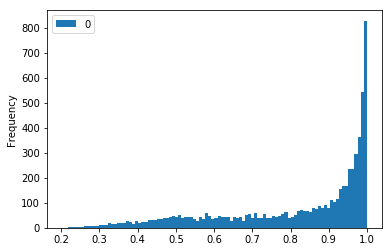

In [16]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,sum
predict_label,,,,,,,,,,
1,1.0,3.0,27.0,82.0,82.0,118.0,121.0,250.0,206.0,890.0
2,2.0,15.0,49.0,100.0,82.0,72.0,112.0,219.0,265.0,916.0
3,0.0,8.0,15.0,25.0,27.0,32.0,28.0,51.0,89.0,275.0
4,0.0,5.0,11.0,28.0,38.0,46.0,47.0,107.0,155.0,437.0
5,6.0,28.0,72.0,98.0,81.0,102.0,95.0,175.0,246.0,903.0
6,1.0,14.0,31.0,34.0,52.0,57.0,98.0,160.0,350.0,797.0
7,1.0,8.0,21.0,41.0,34.0,38.0,59.0,95.0,323.0,620.0
8,3.0,40.0,78.0,119.0,114.0,96.0,136.0,270.0,901.0,1757.0
sum,14.0,121.0,304.0,527.0,510.0,561.0,696.0,1327.0,2535.0,6595.0


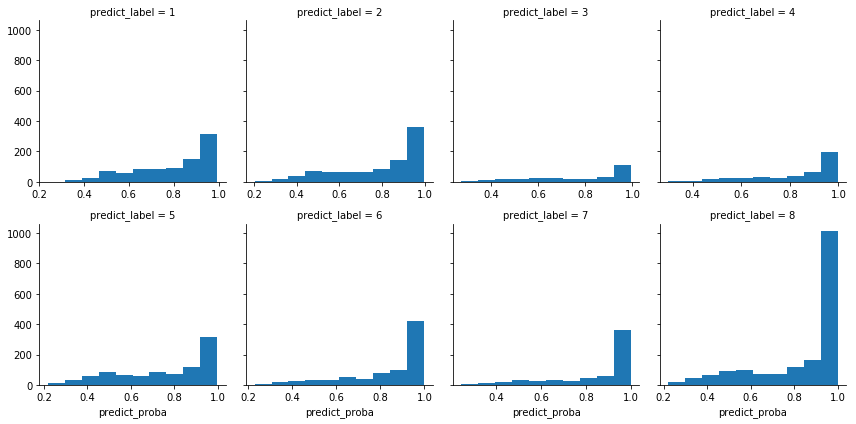

In [17]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob.max(axis = 1))
sel_data_stat

## K-fold

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_cor()),
        ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

filename = 'circ_class_label_proba_20181008.xlsx'
cal_kfold(title_content, label, pipeline, 'circ_result_class', filename)

d:\xh\python_project\tool\toolkits\nlp
d:\xh\python_project\tool\toolkits\nlp
data_raw:  (18022, 5)
---- 1
0.9890407158215995
accuracy_score:  0.860748959778086
             precision    recall  f1-score   support

          1       0.82      0.83      0.83       431
          2       0.84      0.85      0.84       487
          3       0.89      0.73      0.80       187
          4       0.90      0.80      0.85       244
          5       0.80      0.85      0.83       456
          6       0.90      0.93      0.91       388
          7       0.91      0.83      0.86       382
          8       0.87      0.90      0.89      1030

avg / total       0.86      0.86      0.86      3605

confusion_matrix: 
[[358  22   0   1   5   0   1  44]
 [ 18 416   2   2  16   7   3  23]
 [  1   7 136   0  16  13   3  11]
 [  7   8   0 196  12   0   0  21]
 [  4  27   3   3 389   8  11  11]
 [  1   2   1   0   6 361   6  11]
 [  7   8   4   1  25   7 316  14]
 [ 39   8   7  14  15   7   9 931]]
---- 2

In [ ]:
import xlrd

kfold_result = pd.DataFrame()

currentPath  = 'circ_result_class/corpus/circ_class_label_proba_20181008.xlsx'
excel = xlrd.open_workbook(currentPath)
sheet_names = [sheet.name for sheet in excel.sheets()]
for sheet_name in sheet_names:   
    tmp_data = pd.read_excel(currentPath, sheet_name)     
    kfold_result = pd.concat([kfold_result, tmp_data], axis = 0)

kfold_result.index = range(kfold_result.shape[0])
kfold_result.insert(0, '备注', '')
print('总数：', kfold_result.shape)
# kfold_result.head()

In [ ]:
K_S_sel = kfold_result[(kfold_result['predict_proba'] < 0.65) | (kfold_result['R_W'] == 'Wrong')]
K_S_else = kfold_result[~((kfold_result['predict_proba'] < 0.65) | (kfold_result['R_W'] == 'Wrong'))]
print(kfold_result.shape)
print(K_S_else.shape)
print(K_S_sel.shape)
K_S_sel.groupby(['R_W', 'predict_label'])['label'].count()

In [ ]:
fea_filename = 'cbrc_result_class/result/20181008_circ_class_sel.xlsx'
with pd.ExcelWriter(fea_filename) as writer:
    for label in K_S_sel['predict_label'].unique():
        tmp_data = K_S_sel[K_S_sel['predict_label'] == label]
        N = tmp_data.shape[0]
        tmp_data.sample(n = N, axis = 0, random_state=42).to_excel(writer,label, index = False)    
    writer.save()
    
fea_filename = 'cbrc_result_class/result/20181008_circ_class_else.xlsx'
with pd.ExcelWriter(fea_filename) as writer:
    for label in K_S_else['predict_label'].unique():
        tmp_data = K_S_else[K_S_else['predict_label'] == label]
        N = tmp_data.shape[0]
        tmp_data.sample(n = N, axis = 0, random_state=42).to_excel(writer,label, index = False)    
    writer.save()    

In [ ]:
y_test = kfold_result['predict_label'].tolist()
y_pred_class = kfold_result['label'].tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

In [ ]:
y_pred_prob = kfold_result['predict_proba'].tolist()

sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob)
sel_data_stat

## 保存模型

In [18]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_cor()),
        ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

d:\xh\python_project\tool\toolkits\nlp
d:\xh\python_project\tool\toolkits\nlp
0.9705199945407398


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [19]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/circ_8classifier_1015.pkl.z")

['model/circ_8classifier_1015.pkl.z']

# 保险业：2 倾向性

## 导入与分割数据

In [ ]:
cbrc_filepath_class = 'circ_result_tendency/corpus/'
title_content, label = title_content_label(cbrc_filepath_class)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

## train & test

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

In [ ]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

## 概率结果

In [ ]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

In [ ]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob)
sel_data_stat

## K-fold

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

cal_kfold(title_content, label, pipeline)

## 保存模型

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

In [ ]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/circ_chapter_tendency_0905.pkl.z")

# 保险业：3 预警模型

## 导入与分割数据

In [ ]:
cbrc_filepath_class = 'circ_result_warn/corpus/'
title_content, label = title_content_label(cbrc_filepath_class)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

## train & test

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_warn()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

In [ ]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

## 概率结果

In [ ]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

In [ ]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob)
sel_data_stat

## K-fold

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_warn()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

cal_kfold(title_content, label, pipeline)

## 保存模型

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_warn()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

In [ ]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/circ_warning_0621.pkl.z")

# 银行业：1 八分类

## 导入与分割数据

In [20]:
cbrc_filepath_class = 'cbrc_result_class/corpus/'
title_content, label = title_content_label(cbrc_filepath_class)

title num:  11955
['月线 反转 阴包 阳 原油 高 先空 股友 zevS 东方 财富网 博客', '汇乔 金色 名 售 价格 元 平方米']
content num:  11955
title_content num:  11955
label num:  11955
['噪音', '噪音', '噪音', '噪音', '噪音']


In [21]:
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音'}

In [22]:
label = [label_dic[l] for l in label]
label[:5]

[8, 8, 8, 8, 8]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 8368
训练集-各类数量： Counter({8: 1612, 7: 1238, 2: 1043, 1: 1024, 6: 957, 4: 871, 5: 813, 3: 810})
测试集： 3587
测试集-各类数量： Counter({8: 622, 7: 529, 2: 477, 1: 446, 6: 436, 4: 408, 5: 365, 3: 304})


## 生成词典

In [24]:
g_k = generate_keywords(400)
g_k.gen_keywords_by_class(title_content, label, v_thre = 4)

class_label:  [1 2 3 4 5 6 7 8]

依据类别生成关键词：
['金融', '监管', '风险', '银行', '经济', '中国', '工作', '机构', '发展', '业务']
keywords num:  400
类别：1 -- 文本个数：1470，label个数:1470，取词个数：400
['银行', '金融', '业务', '中国', '市场', '风险', '资产', '发展', '贷款', '银行业']
keywords num:  400
类别：2 -- 文本个数：1520，label个数:1520，取词个数：400
['信用卡', '银行', '活动', '理财', '产品', '优惠', '观影', '客户', '享受', '点击']
keywords num:  400
类别：3 -- 文本个数：1114，label个数:1114，取词个数：400
['公司', '银行', '市场', '投资', '股份', '股东', '有限公司', '资金', '中国', '资产']
keywords num:  400
类别：4 -- 文本个数：1279，label个数:1279，取词个数：400
['银行', '分行', '业务', '金融', '行政处罚', '违规', '有限公司', '发展', '中国', '罚款']
keywords num:  400
类别：5 -- 文本个数：1178，label个数:1178，取词个数：400
['银行', '信用卡', '服务', '业务', '办理', '客户', '贷款', '支行', '电话', '申请']
keywords num:  400
类别：6 -- 文本个数：1393，label个数:1393，取词个数：400
['活动', '银行', '支行', '分行', '金融', '知识', '宣传', '中国', '批复', '工作']
keywords num:  400
类别：7 -- 文本个数：1767，label个数:1767，取词个数：400
['公司', '中国', '企业', '市场', '工作', '发展', '投资', '经济', '银行', '服务']
keywords num:  400
类别：8 -- 文本个数：2234，label个数:2

In [25]:
g_k.save_txt('keywords_b.txt')

file_path:  d:\xh\python_project\tool\toolkits\nlp\corpus\keywords_b.txt


## train & test

In [26]:
a = myclass_cbrc.Statskeywords_cor(5000)
len(a.keywords)

d:\xh\python_project\tool\toolkits\nlp
keywords num:  1229


1229

In [27]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', myclass_cbrc.StatsFeatures_cor()),
        ('tf', myclass_cbrc.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

d:\xh\python_project\tool\toolkits\nlp
d:\xh\python_project\tool\toolkits\nlp
keywords num:  1229
0.9945028680688337


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [28]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8561471982157792
             precision    recall  f1-score   support

          1       0.91      0.92      0.91       446
          2       0.84      0.81      0.82       477
          3       0.88      0.89      0.88       304
          4       0.85      0.83      0.84       408
          5       0.83      0.83      0.83       365
          6       0.83      0.81      0.82       436
          7       0.92      0.88      0.90       529
          8       0.81      0.86      0.84       622

avg / total       0.86      0.86      0.86      3587

confusion_matrix: 
[[412  18   0   3   2   1   1   9]
 [ 18 386   7   8  15  14   6  23]
 [  0   3 271   1   5  11   3  10]
 [  7  12   2 340   7  10   0  30]
 [  8  13   0  14 303  12   9   6]
 [  3   9  19   2  11 353   8  31]
 [  0  10   4   3  12  14 468  18]
 [  7   9   6  28   9  11  14 538]]


## 概率结果

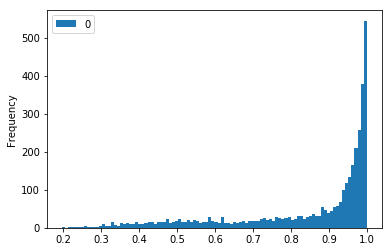

In [29]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,sum
predict_label,,,,,,,,,,
1,0.0,5.0,8.0,22.0,23.0,10.0,30.0,59.0,298.0,455.0
2,1.0,10.0,20.0,26.0,36.0,37.0,50.0,82.0,198.0,460.0
3,1.0,3.0,11.0,22.0,18.0,17.0,22.0,44.0,171.0,309.0
4,0.0,6.0,17.0,29.0,29.0,32.0,56.0,112.0,118.0,399.0
5,0.0,9.0,23.0,18.0,24.0,32.0,45.0,48.0,165.0,364.0
6,3.0,15.0,28.0,22.0,27.0,24.0,27.0,122.0,158.0,426.0
7,1.0,7.0,11.0,20.0,14.0,20.0,30.0,66.0,340.0,509.0
8,2.0,18.0,31.0,53.0,41.0,54.0,67.0,150.0,249.0,665.0
sum,8.0,73.0,149.0,212.0,212.0,226.0,327.0,683.0,1697.0,3587.0


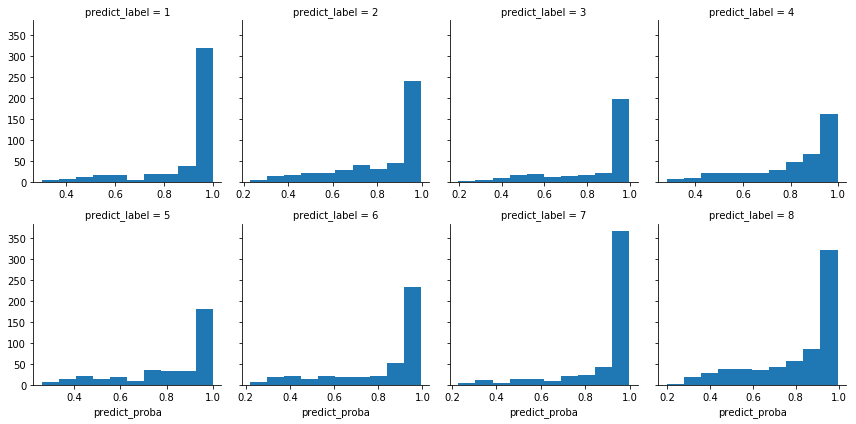

In [30]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob.max(axis = 1))
sel_data_stat

## K-fold

In [10]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_cbrc.StatsFeatures_cor()),
        ('tf', myclass_cbrc.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

filename = 'cbrc_class_label_proba_20180917.xlsx'
cal_kfold(title_content, label, pipeline, 'cbrc_result_class', filename)

d:\xh\python_project\tool\toolkits\nlp
d:\xh\python_project\tool\toolkits\nlp
keywords num:  1314
data_raw:  (9826, 4)
---- 1
0.9968193384223919
accuracy_score:  0.8748728382502543
             precision    recall  f1-score   support

          1       0.88      0.93      0.90       270
          2       0.86      0.84      0.85       256
          3       0.91      0.92      0.92       194
          4       0.84      0.84      0.84       209
          5       0.88      0.83      0.85       203
          6       0.87      0.86      0.87       205
          7       0.92      0.93      0.93       299
          8       0.84      0.84      0.84       330

avg / total       0.87      0.87      0.87      1966

confusion_matrix: 
[[251   9   0   1   1   0   3   5]
 [ 15 214   1   5   6   5   4   6]
 [  1   3 179   1   0   6   2   2]
 [  4   3   2 175   5   4   0  16]
 [  3   8   1   8 168   6   4   5]
 [  1   3   8   1   5 177   2   8]
 [  1   3   2   0   4   1 279   9]
 [ 10   5   3  18   3 

In [28]:
import xlrd

kfold_result = pd.DataFrame()

currentPath  = 'cbrc_result_class/corpus/cbrc_class_label_proba_20180917.xlsx'
excel = xlrd.open_workbook(currentPath)
sheet_names = [sheet.name for sheet in excel.sheets()]
for sheet_name in sheet_names:   
    tmp_data = pd.read_excel(currentPath, sheet_name)     
    kfold_result = pd.concat([kfold_result, tmp_data], axis = 0)

kfold_result.index = range(kfold_result.shape[0])
kfold_result.insert(0, '备注', '')
print('总数：', kfold_result.shape)
# kfold_result.head()

总数： (9826, 8)


,备注,raw_title,raw_content,label,predict_label,title_content,predict_proba,R_W
0,,聚焦今晚PPI数据 黄金或摆脱十字路口徘徊行情,周三(1月10日)，美元遭受暴击，终止三日连涨的走势，黄金获利走高，最高触及近四月高位132...,噪音,噪音,聚焦 今晚 PPI 数据 黄金 摆脱 十字路口 徘徊 行情 周三 月 日 美元 遭受 暴击 ...,0.665914,Right
1,,驻店销售代表（泉港区、前黄、涂岭、山腰）,公司简介PPF集团PPF集团是捷信集团的母公司，是中东欧地区最大的国际金融和投资集团之一，业...,噪音,公司内部管理,驻店 销售 代表 泉港区 前 黄 涂岭 山腰 公司简介 PPF 集团 PPF 集团 捷信 集...,0.274292,Wrong
2,,陈御贺：主力拉盘轰炸避险黄金暴涨20点，后期低多为主,近期美国国债收益率一直稳步走高，在本周二日本央行公布调整购债后，美债价格进一步跌向熊市。日本...,噪音,噪音,陈御 贺 主力 拉盘 轰炸 避险 黄金 暴涨 点 后期 低多 近期 美国 国债 收益率 稳步...,0.898844,Right
3,,华为给员工建3万套福利房，一平米8500元带精装修 | 早报,【国内】 27家乐视供应商发布呼吁对话书，希望与甘薇、贾跃民对话 1月9日晚，记者从一位乐视...,噪音,噪音,华为 员工 建 万套 福利 房 平米 元带 精装修 早报 国内 家乐 视 供应商 发布 呼吁...,0.980682,Right
4,,一个烟酒店老板全干货揭秘：「开店」和「看店」的区别！,“我是个小烟酒店的老板，我的生意不大，但是我总结出不少生意经，献丑和大家说说，但愿抛砖引玉，...,噪音,噪音,烟酒 店老板 全 干货 揭秘 开店 看店 区别 小烟 酒店 老板 生意 生意经 献丑 说 说...,0.984564,Right


In [29]:
K_S_sel = kfold_result[(kfold_result['predict_proba'] < 0.65) | (kfold_result['R_W'] == 'Wrong')]
K_S_else = kfold_result[~((kfold_result['predict_proba'] < 0.65) | (kfold_result['R_W'] == 'Wrong'))]
print(kfold_result.shape)
print(K_S_else.shape)
print(K_S_sel.shape)
K_S_sel.groupby(['R_W', 'predict_label'])['label'].count()

(9826, 8)
(8196, 8)
(1630, 8)


R_W    predict_label
Right  产品销售              42
       公司内部管理            42
       其他相关报道            36
       噪音                95
       消费服务              53
       监管                53
       行业                89
       资本市场              87
Wrong  产品销售              94
       公司内部管理            98
       其他相关报道           126
       噪音               251
       消费服务             110
       监管               129
       行业               186
       资本市场             139
Name: label, dtype: int64

In [30]:
fea_filename = 'cbrc_result_class/result/20180918_cbrc_class_sel.xlsx'
with pd.ExcelWriter(fea_filename) as writer:
    for label in K_S_sel['predict_label'].unique():
        tmp_data = K_S_sel[K_S_sel['predict_label'] == label]
        N = tmp_data.shape[0]
        tmp_data.sample(n = N, axis = 0, random_state=42).to_excel(writer,label, index = False)    
    writer.save()
    
fea_filename = 'cbrc_result_class/result/20180918_cbrc_class_else.xlsx'
with pd.ExcelWriter(fea_filename) as writer:
    for label in K_S_else['predict_label'].unique():
        tmp_data = K_S_else[K_S_else['predict_label'] == label]
        N = tmp_data.shape[0]
        tmp_data.sample(n = N, axis = 0, random_state=42).to_excel(writer,label, index = False)    
    writer.save()    

In [12]:
y_test = kfold_result['predict_label'].tolist()
y_pred_class = kfold_result['label'].tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8846936698554855
             precision    recall  f1-score   support

       产品销售       0.90      0.90      0.90       939
     公司内部管理       0.84      0.90      0.86       934
     其他相关报道       0.93      0.92      0.92      1533
         噪音       0.88      0.85      0.86      1656
       消费服务       0.87      0.89      0.88      1037
         监管       0.94      0.91      0.92      1429
         行业       0.86      0.86      0.86      1291
       资本市场       0.84      0.86      0.85      1007

avg / total       0.89      0.88      0.88      9826

confusion_matrix: 
[[ 845    5    6   19   44    0   12    8]
 [   5  836   24   12   13    5   25   14]
 [  19   33 1407   38   16    6   12    2]
 [  23   17   45 1405   34   25   35   72]
 [  29   18    9   13  927    2    9   30]
 [   4   17    6   27    8 1300   55   12]
 [  14   46   10   24   15   45 1105   32]
 [   5   28    6   60    4    5   31  868]]


proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,sum
predict_label,,,,,,,,,,
产品销售,3.0,13.0,11.0,34.0,38.0,39.0,41.0,114.0,651.0,944.0
公司内部管理,1.0,21.0,31.0,38.0,41.0,44.0,69.0,126.0,629.0,1000.0
其他相关报道,0.0,12.0,20.0,31.0,26.0,43.0,55.0,155.0,1171.0,1513.0
噪音,1.0,25.0,41.0,57.0,60.0,110.0,150.0,334.0,820.0,1598.0
消费服务,1.0,27.0,28.0,40.0,35.0,45.0,52.0,147.0,686.0,1061.0
监管,1.0,8.0,16.0,24.0,45.0,54.0,96.0,192.0,952.0,1388.0
行业,3.0,14.0,35.0,67.0,57.0,77.0,100.0,230.0,701.0,1284.0
资本市场,2.0,10.0,24.0,72.0,56.0,85.0,101.0,240.0,448.0,1038.0
sum,12.0,130.0,206.0,363.0,358.0,497.0,664.0,1538.0,6058.0,9826.0


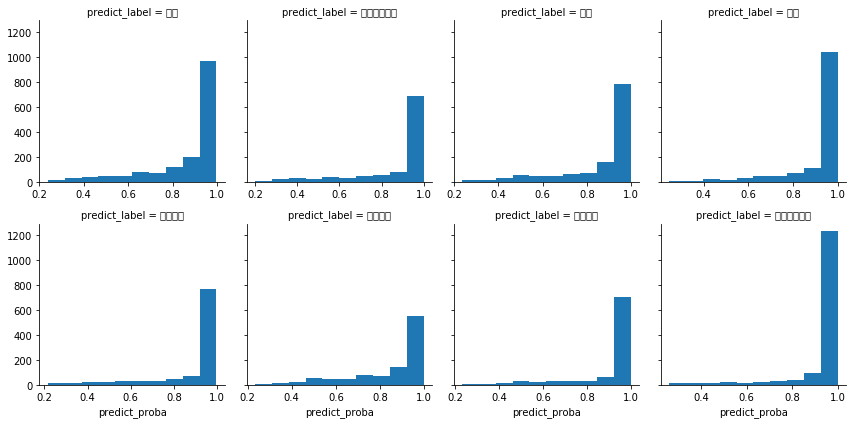

In [13]:
y_pred_prob = kfold_result['predict_proba'].tolist()

sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob)
sel_data_stat

## 保存模型

In [31]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_cbrc.StatsFeatures_cor()),
        ('tf', myclass_cbrc.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

d:\xh\python_project\tool\toolkits\nlp
d:\xh\python_project\tool\toolkits\nlp
keywords num:  1229
0.9902132998745294


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [32]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/cbrc_8classifier_1015.pkl.z")

['model/cbrc_8classifier_1015.pkl.z']

# 银行业：2 倾向性

## 导入与分割数据

In [ ]:
cbrc_filepath_class = 'cbrc_result_tendency/corpus/'
title_content, label = title_content_label(cbrc_filepath_class)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

## train & test

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_cbrc.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

In [ ]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

## 概率结果

In [ ]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

In [ ]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob)
sel_data_stat

## K-fold

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_cbrc.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

cal_kfold(title_content, label, pipeline)

## 保存模型

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_cbrc.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

In [ ]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/cbrc_chapter_tendency_0622.pkl.z")

# 保存本文件

In [ ]:
if 0:
    import datetime as dt
    
    def output_HTML(read_file, output_file):
        from nbconvert import HTMLExporter
        import codecs
        import nbformat
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    html_file_folder = 'html_files'
    if not os.path.exists(html_file_folder):
        os.makedirs(html_file_folder)

    today = dt.datetime.now().strftime('%Y%m%d')
    current_file = 'circ_cor_model_2_train.ipynb'
    output_file = 'html_files\%s_%s.html'%(os.path.splitext(current_file)[0], today)
    output_HTML(current_file, output_file)